# 11. GAN

생성적 적대 신경망은 아이디어 자체로만으로도 매우 가치있는 모델로 평가 받고 있다. 실제 얼굴 변환, 생성, 음성 변조, 그림 스타일 변환, 사진 복원 등 다양한 기술로 응용이 되어 실제 적용되고 있다.

## 11.1 라이브러리 및 데이터 불러오기

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import imageio
from tqdm import trange

import numpy as np
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd/content/gdrive/My Drive/deeplearningbrov2/pytorch

/content/gdrive/My Drive/deeplearningbrov2/pytorch


In [ ]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
to_image = transforms.ToPILImage()
trainset = FashionMNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 'T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'

## 11.2 모델 정의

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784
        self.linear = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(0.2),
                    nn.Linear(256, 512),
                    nn.LeakyReLU(0.2),
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Linear(1024, self.n_out),
                    nn.Tanh()
                    )
 
    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 1, 28, 28)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.linear = nn.Sequential(
                    nn.Linear(self.n_in, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(256, self.n_out),
                    nn.Sigmoid()
                    )
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.linear(x)
        return x

## 11.3 손실함수 및 최적화 방법 정의

In [6]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

pretrained =  False
if pretrained == True:
    discriminator.load_state_dict(torch.load('./models/fmnist_disc.pth'))
    generator.load_state_dict(torch.load('./models/fmnist_gner.pth'))

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []
images = []

criterion = nn.BCELoss()

def noise(n, n_features=128):
    return Variable(torch.randn(n, n_features)).to(device)

def label_ones(size):
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def label_zeros(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

## 11.4 학습 전략 정의

In [7]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)

    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    d_loss = criterion(prediction_real, label_ones(n))

    prediction_fake = discriminator(fake_data)
    g_loss = criterion(prediction_fake, label_zeros(n))
    
    loss = d_loss + g_loss

    loss.backward()
    optimizer.step()
    
    return loss.item()

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    loss = criterion(prediction, label_ones(n))
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

## 11.5 학습하기

In [ ]:
num_epochs = 101
pbar = trange(num_epochs)
test_noise = noise(64)

l = len(trainloader)

for epoch in pbar:
    g_loss = 0.0
    d_loss = 0.0

    for data in trainloader:
        imgs, _ = data
        n = len(imgs)
        
        fake_data = generator(noise(n)).detach()
        real_data = imgs.to(device)
        d_loss += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(noise(n))
        g_loss += train_generator(g_optim, fake_data)

    img = generator(test_noise).cpu().detach()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_loss/l)
    d_losses.append(d_loss/l)

    pbar.set_postfix({'epoch': epoch+1, 'g_loss' : g_loss/l, 'd_loss' : d_loss/l}) 


torch.save(discriminator.state_dict(), './models/fmnist_disc.pth') 
torch.save(generator.state_dict(), './models/fmnist_gner.pth')   


## 11.6 이미지 결과 및 손실함수 그래프 생성

In [ ]:
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('./results/fashion_items_vnlgan.gif', imgs)

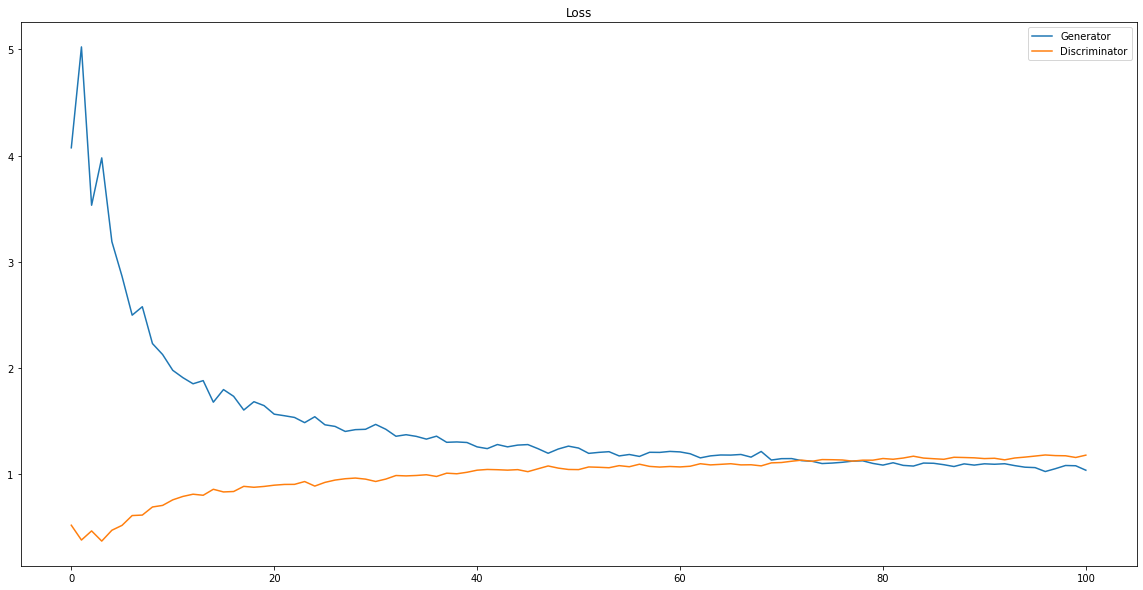

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Generator','Discriminator'])
plt.title('Loss')
plt.savefig('./results/vnlgan_loss.png')